<a href="https://colab.research.google.com/github/nathamon24/image-processing/blob/main/Activity/Activity%235/Lab5_90_90_3K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

5.1 DATA PREPARATION

In [11]:
# List all filename in face image path
filenames= glob.glob(f"/content/drive/MyDrive/Work/CE/Colab/face_mini/**/*.jpg")
height,width,ch = 90,90,3
all_imgs = []
for i in range(len(filenames)):
  # Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
  img = load_img(filenames[i], grayscale=False, color_mode='rgb', target_size = (height,width,ch), interpolation="nearest")
  # convert the image to an array
  img = img_to_array(img)
  # Normalized color image
  img = img/255
  all_imgs.append(img)

# convert to numpy array
all_images = np.array(all_imgs)

# split data into train and validation data
x_train, x_test = train_test_split(all_images, random_state=32, test_size=0.3)
x_train, x_val = train_test_split(x_train, random_state=32, test_size=0.3)

5.2 ADD NOISE

<Figure size 432x288 with 0 Axes>

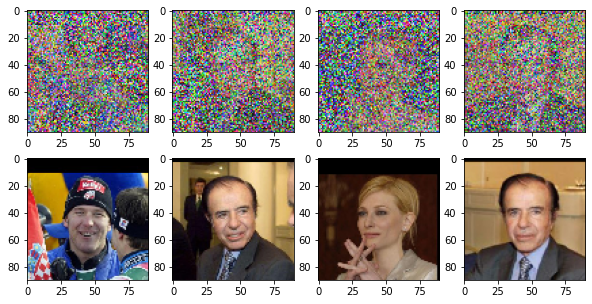

In [12]:
# Add Noise กำหนด noise factor (noise level)
# Add noise
noise_factor1 = 0.25
noise_factor2 = 0.5
noise_factor3 = 0.75

noise_factor = noise_factor1
# กำหนด noise parameter
# Noise distribution: normal
# Noise mean: zero mean (Nmean = 0)
Nmean = 0
# Noise std: unit variance (Nstd = 1)
Nstd = 1

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = x_train + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_train.shape))
x_val_noisy = x_val + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_val.shape))
x_test_noisy = x_test + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_test.shape) )

#display noisy images
plt.figure()
f1, axarr1 = plt.subplots(2,4,figsize=(10,5)) 
for i in range(4):
  axarr1[0][i].imshow((x_train_noisy[i]* 255).astype(np.uint8))
  axarr1[1][i].imshow((x_train[i]* 255).astype(np.uint8))

5.3 Autoencoder Architecture

In [13]:
# กำหนด Encoder Architecture
Input_img = Input(shape=(height, width, ch))
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# กำหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
decoded = Conv2D(3, (3, 3), padding='same')(x5)

# กำหนด optimizer setting
autoencoder = Model(Input_img, decoded)
#vv loss ใช้ Mean Square Error
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 256)       7168      
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)        73792     
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)        36928     
                                                           

Epoch 1/4
99/99 [==============================] - 30s 276ms/step - loss: 0.0157 - val_loss: 0.0053
Epoch 2/4
99/99 [==============================] - 27s 277ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 3/4
99/99 [==============================] - 26s 261ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/4
99/99 [==============================] - 26s 260ms/step - loss: 0.0041 - val_loss: 0.0039


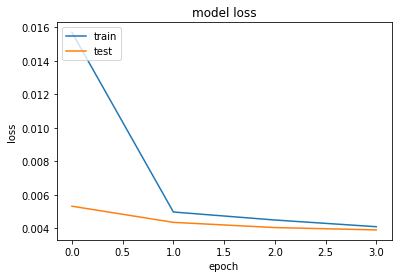

<Figure size 432x288 with 0 Axes>

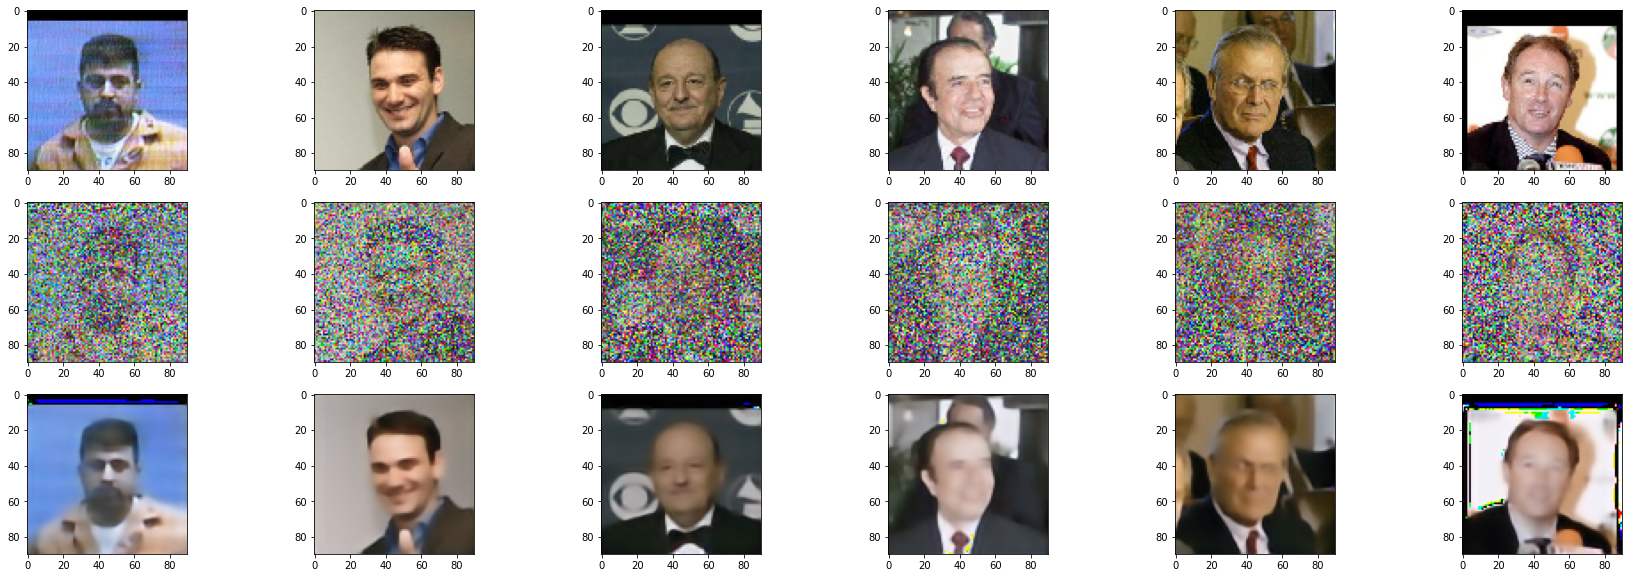

In [14]:
# กำหนด Training parameter
#epoch ทดลองอย่ำงน้อย 2 ค่ำ [ 2, 3, 4 ]
epoch = 4
#batch_size ทดลองอย่ำงน้อย 1 ค่ำ [8, 16, 32]
batch_size = 16

# เริ่มการ training
history = autoencoder.fit (x_train_noisy, x_train,
          epochs= epoch,
          batch_size= batch_size,
          shuffle= True,
          validation_data= (x_val_noisy, x_val)
          # validation_data= (x_val_noisy, x_val),
          ,callbacks=[EarlyStopping(monitor='loss', patience=5)])

# ทดสอบ autoencoder model ด้วย validation
predictions = autoencoder.predict(x_val_noisy)
predictions = autoencoder.predict(x_test_noisy)

#View Loss from history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Display Result image
plt.figure()
f, axarr = plt.subplots(3,6, figsize=(30,10)) 
predicted_imgs = autoencoder.predict(x_test)
for i in range(6):
  axarr[0][i].imshow((x_test[i]*255).astype(np.uint8))
  axarr[1][i].imshow((x_test_noisy[i]*255).astype(np.uint8))
  axarr[2][i].imshow((predicted_imgs[i]*255).astype(np.uint8))
